## Elementos finitos linear 1D

## Montar a matrix de massa

In [58]:
using Jacobi

## Funções

In [59]:
remap(x,a,b) = ((1-x)*a + (1+x)*b)/2

remap (generic function with 1 method)

In [60]:
function ψj(p,E,Q)
    if(p == 1)
     return  (1-E)/2
        elseif(p == 2)
     return  (1+E)/2
    else
     return  (1-E)*(1+E)/4 .* jacobi(E, p-3, 1, 1)
    end
end 

ψj (generic function with 1 method)

In [61]:
function  ϕ_matrix(ψj,Q,M)
    ϕ = zeros(Q,M)
    ξ = zglj(Q)
    for i in 1:M
        for j in 1:Q
            ϕ[j,i] = ψj(i,ξ[j],M)
        end
    end
  return ϕ
end

ϕ_matrix (generic function with 1 method)

In [62]:
function  ϕ_matrix_interp(ψj,Q,M)
    ϕ = zeros(Q,M)
    ξ = linspace(-1,1,Q)
    for i in 1:M
        for j in 1:Q
            ϕ[j,i] = ψj(i,ξ[j],M)
        end
    end
  return ϕ
end

ϕ_matrix_interp (generic function with 1 method)

In [63]:
function Me_matrix(ϕ,w,M,Q,a,b)
    L = zeros(M,M)
    jac = (b-a)/2
    for i in 1:M
        for j in 1:M
           m= 0.0
            for q in 1:Q
                m = m + ϕ[q,i]*ϕ[q,j]*w[q]*jac
            end
            L[i,j] = m
        end
    end
    return L
end

Me_matrix (generic function with 1 method)

### $ϕ$ e  matriz de massa

In [64]:
Nel = 5
I = 5
nb = Nel + 1
ni = (I-2)
Q = I+2

#indices locais
ib = collect(1:2)
ii = collect(3:I)

#limites
a = -1; 
b = 1;

z = zglj(Q)
w = wglj(z)
ϕ = ϕ_matrix(ψj,Q,I);
xn = [linspace(a,b,Nel+1);];
X = zeros(Q,Nel)
remap(x,a,b) = ((1-x)*a + (1+x)*b)/2
for e in 1:Nel
    X[:,e] = [remap(x,xn[e],xn[e+1]) for x in z]
end
X

7x5 Array{Float64,2}:
 -1.0       -0.6       -0.2        0.2       0.6     
 -0.966045  -0.566045  -0.166045   0.233955  0.633955
 -0.89377   -0.49377   -0.0937698  0.30623   0.70623 
 -0.8       -0.4        0.0        0.4       0.8     
 -0.70623   -0.30623    0.0937698  0.49377   0.89377 
 -0.633955  -0.233955   0.166045   0.566045  0.966045
 -0.6       -0.2        0.2        0.6       1.0     

In [65]:

dof_map = zeros(Int, 2, Nel)
for i = 1:Nel
    dof_map[1,i] = i
    dof_map[2,i] = i+1
end
dof_map

2x5 Array{Int64,2}:
 1  2  3  4  5
 2  3  4  5  6

In [66]:

using Base.LinAlg.BLAS.gemm!
using Base.LinAlg.BLAS.gemv!
using Base.LinAlg.LAPACK.potrf!
using Base.LinAlg.LAPACK.potrs!

### $ A_{bb}^* = (A_{bb} - A_{bi} A_{ii}^{-1} A_{ib})  $

In [67]:
Abb = zeros(Nel+1,Nel+1)
M = Vector{Array{Float64,2}}(Nel)
Mii = Vector{Array{Float64,2}}(Nel)
for e in 1:Nel
    Me = Me_matrix(ϕ, w, I, Q, xn[e], xn[e+1]) ;


    
    Mbb = Me[ib,ib]
    Mbi = Me[ib,ii]
    Mib = Me[ii,ib]
    Mii[e] = Me[ii,ii]
    
    potrf!('L',Mii[e]); #Mii^-1
    M[e] = copy(Mib)
    potrs!('L',Mii[e],M[e]) # M = Mii^-1 * Mbi
    gemm!('T', 'N', -1.0, M[e], Mib, 1.0, Mbb) # Mbb = -1*M*Mib + Mbb
    
    for i in 1:2
        ig = dof_map[i,e]
        for j in 1:2
            jg = dof_map[j,e]
            Abb[ig,jg] += Mbb[i,j]
        end
    end
end

potrf!('L',Abb);


## RHS

In [68]:
fun(x) = cos(2*pi*x)
#calcula F
Fe = zeros(I,Nel)
for e = 1:Nel
    jac = (xn[e+1] - xn[e] )/2
    for i in 1:I
        temp = 0.0
        for q in 1:Q
            temp += fun(X[q,e])* ϕ[q,i] * w[q] * jac
        end
        Fe[i,e] = temp
    end
end
Fe

5x5 Array{Float64,2}:
  0.114557    -0.164349     0.151365     -0.080565    -0.0210084 
 -0.0210084   -0.080565     0.151365     -0.164349     0.114557  
  0.0175261   -0.045884     0.0567158    -0.045884     0.0175261 
 -0.0284294    0.0175703    8.67362e-19  -0.0175703    0.0284294 
 -0.00255244   0.00668237  -0.00825986    0.00668237  -0.00255244

In [69]:
B = Fe[:,1]
Bb = B[ib]
Bi = B[ii];

### $f_b^* =f_b - A_{bi} A_{ii}^{-1} f_i$

In [70]:
Fb = zeros(nb)

for e in 1:Nel
    fe  = Fe[:,e]
    fb  = fe[ib]
    fi  = fe[ii]
    gemv!('T',-1.0,M[e],fi, 1.0, fb) #fbb = -1*M^T*fi + fb

    for i in 1:2
        ig = dof_map[i,e]
        Fb[ig] += fb[i]
    end

end
Fb

6-element Array{Float64,1}:
  0.0193062
 -0.0312381
  0.0119319
  0.0119319
 -0.0312381
  0.0193062

# Solve   $A^*_{bb}\ u_b =\ f^*_b$

In [71]:
Abb

6x6 Array{Float64,2}:
  0.129099   -0.00333333   0.0          0.0          0.0          0.0       
 -0.0258199   0.180739    -0.00333333   0.0          0.0          0.0       
  0.0        -0.0184428    0.18164     -0.00333333   0.0          0.0       
  0.0         0.0         -0.0183513    0.18165     -0.00333333   0.0       
  0.0         0.0          0.0         -0.0183504    0.18165     -0.00333333
  0.0         0.0          0.0          0.0         -0.0183503    0.127789  

In [72]:
Ue = zeros(I,Nel)

potrs!('L',Abb,Fb)
Ub = Fb


6-element Array{Float64,1}:
  0.997046
 -0.806627
  0.308104
  0.308104
 -0.806627
  0.997046

### $u_i = A_{ii}^{-1}f_i - A_{ii}^{-1} A_{bi}^t u_b$

In [73]:
U = zeros(I,Nel)
for e in 1:Nel
    ub  = Ub[vec(dof_map[:,e])]
    fe  = Fe[:,e]
    fi  = fe[ii]

    potrs!('L',Mii[e],fi)
    gemv!('N',-1.0,M[e],ub,1.0,fi) #fi = -1*M*ub + fi
    
    U[ib,e]= ub
    U[ii,e] = fi
end
U

5x5 Array{Float64,2}:
  0.997046   -0.806627   0.308104     0.308104  -0.806627 
 -0.806627    0.308104   0.308104    -0.806627   0.997046 
  0.83182    -2.17773    2.69183     -2.17773    0.83182  
 -0.574926    0.355324  -1.9984e-15  -0.355324   0.574926 
 -0.0307666   0.080548  -0.0995628    0.080548  -0.0307666

In [74]:
Uh = zeros(Q,Nel)
for e in 1:Nel
    Uh[:,e] = ϕ*U[:,e]
end
Uh

7x5 Array{Float64,2}:
  0.997046  -0.806627  0.308104   0.308104  -0.806627
  0.978326  -0.915522  0.50302    0.101618  -0.667442
  0.784981  -0.999157  0.831689  -0.346544  -0.270969
  0.308933  -0.808798  0.999729  -0.808798   0.308933
 -0.270969  -0.346544  0.831689  -0.999157   0.784981
 -0.667442   0.101618  0.50302   -0.915522   0.978326
 -0.806627   0.308104  0.308104  -0.806627   0.997046

In [75]:
using PyPlot

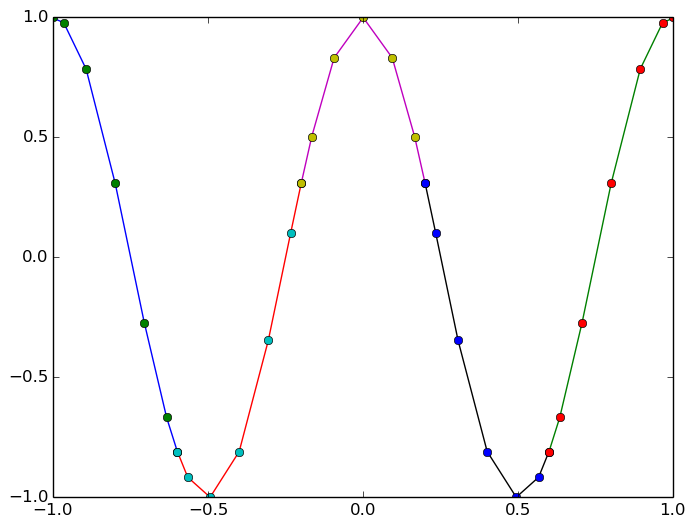

In [76]:
for e in 1:Nel
    plot(X[:,e],Uh[:,e])
    plot(X[:,e],fun(X[:,e]),"o")
#    legend()
end
